# 1. Business & Data Understanding

Build a model that can classify whether a given patient has pneumonia, given a chest x-ray image.

## Import Libraries and Image Files

In [1]:
import warnings
warnings.filterwarnings('ignore')
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, Adadelta, Adagrad, SGD, RMSprop

Using TensorFlow backend.

Bad key "text.kerning_factor" on line 4 in
/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Get the Directory Paths of the Image sets
train_dir = 'chest_xray/train/'
val_dir = 'chest_xray/val/'
test_dir = 'chest_xray/test/'

### Preview Images

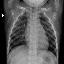

In [222]:
# Image 20
array_to_img(train_images[20])

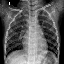

In [221]:
# Image 8
array_to_img(val_images[8])

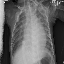

In [220]:
# Image 200
array_to_img(test_images[200])

# 2. Data Preparation

## Addressing Class Imbalance

There are 1341 "normal" chest x-rays and 3875 bacterial/viral pneumonia x-rays. Generate 2534 more normal images to balance out the dataset.

In [78]:
# Establish the criteria for data augementation; create random transformation of images
datagen = ImageDataGenerator(
            rotation_range = 40,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            rescale = 1./255,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            fill_mode = 'nearest')

In [79]:
# Select a random normal image to transform. Put the image path into load_img
img = load_img('chest_xray/train/NORMAL/IM-0757-0001.jpeg')

In [80]:
# Get the size of the image
img.getpixel

<bound method Image.getpixel of <PIL.Image.Image image mode=RGB size=1284x1086 at 0x7FB98CB47240>>

In [81]:
# Convert the image to an array
img_array = img_to_array(img)

In [82]:
# Get the shape of the image array
img_array.shape

(1086, 1284, 3)

In [83]:
# Reshape the array to an (1 x n) array
img_array = img_array.reshape((1,) + img_array.shape)
img_array.shape

(1, 1086, 1284, 3)

In [85]:
# Store the file path to Generated Images Test to the variable "gen_dir"
gen_dir = 'Generated_Drafts/'

In [87]:
# Add 90 "test" images to gen_dir in batches of 30 to verify that the code works as intended
count = 0
for batch in datagen.flow(img_array, batch_size=30, save_to_dir=gen_dir, save_prefix='IM', save_format='jpeg'):
    count +=1
    if count == 90:
        break
        
print('90 images have been generated at', gen_dir)


90 images have been generated at Generated_Drafts/


In [88]:
# Add the Normal X-ray Training file path
norm_dir = 'chest_xray/train/NORMAL/'

# Add 2534 Images to the file path in batches of 150
count = 0
for batch in datagen.flow(img_array, batch_size=150, save_to_dir=norm_dir, save_prefix='IM', save_format='jpeg'):
    count +=1
    if count == 2534:
        break
        
print('2534 images have been generated at', norm_dir)

2534 images have been generated at Generated_Drafts/


In [89]:
# The previous code block stopped 279 images short of 2534. This block, adds them to the Normal Chest Training File Path
count = 0
for batch in datagen.flow(img_array, batch_size=31, save_to_dir=norm_dir, save_prefix='IM', save_format='jpeg'):
    count +=1
    if count == 279:
        break
        
print('279 additional images have been generated at', norm_dir)

279 additional images have been generated at chest_xray/train/NORMAL/


## Preprocessing

### Read in Images

In [3]:
# Resize all 7685 images in the train directory
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir,
                                                          target_size = (64, 64), batch_size= 7685)

Found 7685 images belonging to 2 classes.


In [4]:
# Resize all 16 images in the val directory
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir,
                                                        target_size = (64, 64), batch_size=16)



Found 16 images belonging to 2 classes.


In [5]:
# Resize all 624 images in the val directory
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                          target_size = (64, 64), batch_size=624)



Found 624 images belonging to 2 classes.


In [6]:
# Iterate through all of the images and create image-label datasets stored into "X_images" and "X_labels"
train_images, train_labels = next(train_generator)

In [7]:
val_images, val_labels = next(val_generator)

In [8]:
test_images, test_labels = next(test_generator)

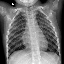

In [96]:
# Preview an Image
array_to_img(train_images[80])

## Check the Shape of the Image & Label Arrays

In [97]:
print('Shape of Train Images: ', np.shape(train_images))
print('Shape of Train Labels: ', np.shape(train_labels))
print('Shape of Validation Images: ', np.shape(val_images))
print('Shape of Validation Labels: ', np.shape(val_labels))
print('Shape of Test Images: ', np.shape(test_images))
print('Shape of Test Labels: ', np.shape(test_labels))

Shape of Train Images:  (7685, 64, 64, 3)
Shape of Train Labels:  (7685, 2)
Shape of Validation Images:  (16, 64, 64, 3)
Shape of Validation Labels:  (16, 2)
Shape of Test Images:  (624, 64, 64, 3)
Shape of Test Labels:  (624, 2)


## Transform Label Matrices

In [9]:
# Transform the labels to (m X 1) matrices
train_labels_final = np.reshape(train_labels[:,0], (7685,1))
np.shape(train_labels_final)

(7685, 1)

In [10]:
val_labels_final = np.reshape(val_labels[:,0], (16,1))
np.shape(val_labels_final)

(16, 1)

In [11]:
test_labels_final = np.reshape(test_labels[:,0], (624,1))
np.shape(test_labels_final)

(624, 1)

In [33]:
# Verify the Class Labels
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

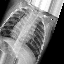

In [103]:
# Select a random image to verify
array_to_img(train_images[4000])

In [104]:
# Return the respective label and verify that the label matches the image
train_labels_final[4000, :]

array([1.], dtype=float32)

## 3. Modeling & Evaluation

Build a convolutional neural network and fit the resulting deep learning model to the training dataset. Test on the Validation Dataset until optimal performance is achieved, then validate the model on the test set.

## Model 1: Default Settings, No Added Regularization or Normalization Techniques

In [105]:
# Build the CNN
# Convolution & Pooling
model2 = Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))

# Flattening- Convert 2D matrix to a 1D vector
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation = 'relu'))
model2.add(layers.Dense(1, activation='softmax'))



In [106]:
# Return the summary of the model
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
__________

In [107]:
# Compile the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [122]:
# Employ the earyl stopping callback to stop the model when the validation loss has stopped improving, then save the resulting model with the file name "best_model.h5"
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [123]:
# Train the model
results2 = model2.fit(train_images, train_labels_final, epochs=100, callbacks=early_stopping, batch_size=500, validation_data=(val_images, val_labels_final))

Train on 7685 samples, validate on 16 samples
Epoch 1/100
7685/7685 [==============================] - 71s 9ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/100
7685/7685 [==============================] - 60s 8ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/100
7685/7685 [==============================] - 58s 8ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/100
7685/7685 [==============================] - 58s 8ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/100
7685/7685 [==============================] - 65s 8ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 6/100
7685/7685 [==============================] - 120s 16ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 7/100
7685/7685 [==============================] - 99s 13ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_acc: 0.5000

In [124]:
# Evaluate the model and return the final loss and accuacy for the training set
results_train2 = model2.evaluate(train_images, train_labels_final)
results_train2

7685/7685 [==============================] - 28s 4ms/step


[8.03861348518863, 0.4957709824488236]

In [125]:
# Evaluate the model and return the final loss and accuacy for the validation set
results_val2 = model2.evaluate(val_images, val_labels_final)
results_val2

16/16 [==============================] - 0s 5ms/step


[7.971192359924316, 0.5]

In [12]:
# Plot the Loss and Accuracy
def visualize_training_results(results):
    """
   1 Input: The Training and 
    Validation/Testing Dictionary 
    of Loss and Accuracy
    
    Output: 2 Plots of Loss vs. Epochs
    and Accuracy vs. Epochs
    """
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

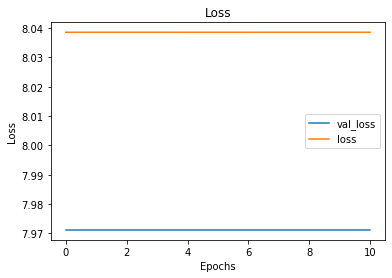

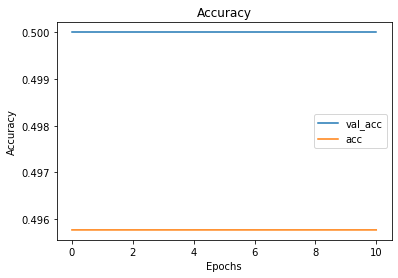

In [127]:
visualize_training_results(results2)

Fixing the class imbalance, doubled both the training and validation accuracies. The original model, that was run and removed here was done on images 150 x 150 on the priginal unbalanced dataset, and yielded an accuracy of 0.256; however the model is slightly overfit, (low variance). The next several models will focus on tuning the hyperparaemters to decrease loss, and reduce the variance so that the model coverges.

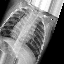

In [115]:
# Use this image for testing the model predictions
sample_img = array_to_img(train_images[4000])
sample_img

In [162]:
# Make Predictions
preds2 = model2.predict(val_images)

In [163]:
# Print the classification report showing the metrics Recall, Precision, and F1-Score
classification_report =classification_report(val_labels_final, preds2)
classification_report

'              precision    recall  f1-score   support\n\n         0.0       0.00      0.00      0.00         8\n         1.0       0.50      1.00      0.67         8\n\n    accuracy                           0.50        16\n   macro avg       0.25      0.50      0.33        16\nweighted avg       0.25      0.50      0.33        16\n'

In [13]:
# Plot a confusion matrix
def plot_confusion_matrix(labels, preds):
    """
    Input: Validation/Testing Labels and
    model predictions
    
    Output: A confusion matrix
    
    """
    
    cnf_matrix = confusion_matrix(labels, preds)

    # Create the basic confusion matrix
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

    # Add title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add appropriate axis scales
    y = train_generator.class_indices
    class_names = set(y) # Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Add labels to each cell
    thresh = cnf_matrix.max() / 2. # Used for text coloring below
    # Here we iterate through the confusion matrix and append labels to our visualization 
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment='center',
                     color='white' if cnf_matrix[i, j] > thresh else 'black')

    # Add a legend
    plt.colorbar()
    plt.show()

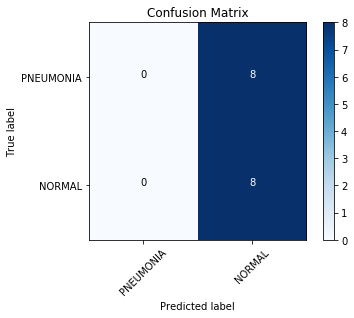

In [176]:
plot_confusion_matrix(val_labels_final, preds2)

## Model 3: Hyperparameter Tuning: Optimizers + Early Stopping Criteria

In [130]:
# Create a dictionary of optimizer, and assign different colors to the optimizers for plotting the model's loss
optimizers = {"RMSprop": {"optimizer": RMSprop(), "color":"blue"},
                  "adam_01": {"optimizer": Adam(lr=0.01), "color":"red"},
                  "sgd": {"optimizer": SGD(), "color":"purple"},
                  "adadelta": {"optimizer": Adadelta(), "color":"pink"},
                  "adagrad": {"optimizer": Adagrad(), "color":"yellow"}}

In [131]:
# Iterate through the optimizer dictionary and compile the model with each optimizer
for optimizer, d in optimizers.items():
    print(f'Testing {optimizer}')
    
    # Build the CNN
    # Convolution & Pooling
    
    model3 = Sequential()

    
    model3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model3.add(layers.MaxPooling2D((2, 2)))
    
    model3.add(layers.Conv2D(32, (4, 4), activation='relu'))
    model3.add(layers.MaxPooling2D((2, 2)))

    model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model3.add(layers.MaxPooling2D((2,2)))

    # Flattening
    model3.add(layers.Flatten())
    model3.add(layers.Dense(64, activation = 'relu'))
    model3.add(layers.Dense(1, activation='softmax'))
    
    model3.compile(optimizer=d['optimizer'],loss='binary_crossentropy', metrics=['accuracy'])

    
    results3 = model3.fit(train_images, train_labels_final, epochs=15, batch_size=500, validation_data=(val_images, val_labels_final))

    print("Stored Results")
    # d['loss'] = history.history['loss'] run this line
    print('='*125)

Testing RMSprop
Train on 7685 samples, validate on 16 samples
Epoch 1/15
7685/7685 [==============================] - 171s 22ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/15
7685/7685 [==============================] - 77s 10ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/15
7685/7685 [==============================] - 70s 9ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/15
7685/7685 [==============================] - 59s 8ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/15
7685/7685 [==============================] - 64s 8ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 6/15
7685/7685 [==============================] - 59s 8ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 7/15
7685/7685 [==============================] - 61s 8ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 7.9712 - val_ac

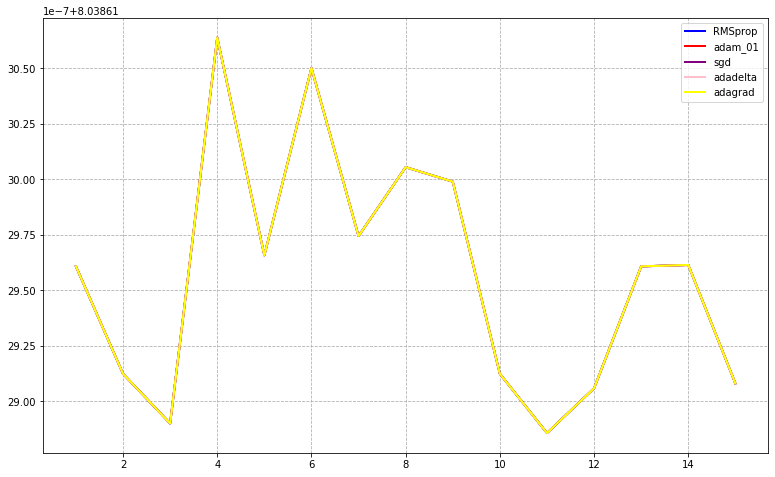

In [198]:
# Plot Training Loss
plt.figure(figsize=(13, 8))
plt.grid(linestyle='dashed')
epochs = 15
for optimizer, d in optimizers.items():
    lss = results3.history['loss']
    color = d['color']
    plt.plot(range(1, epochs+1), lss, c=color, label=optimizer, linewidth=2)
plt.legend()
plt.show()

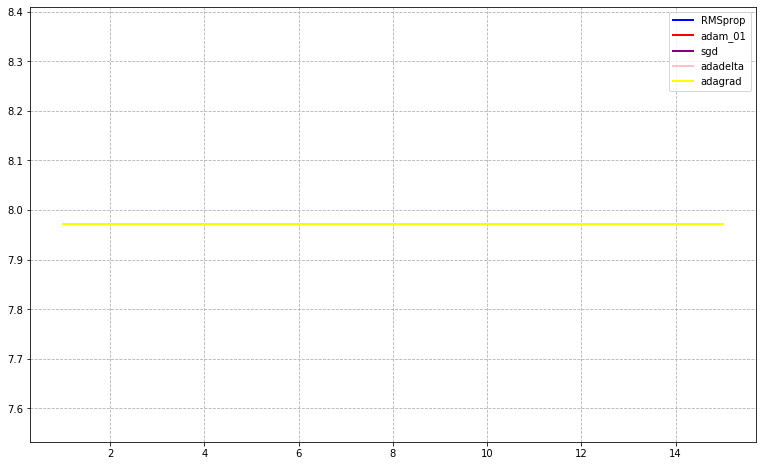

In [199]:
# Plot Validation Loss
plt.figure(figsize=(13, 8))
plt.grid(linestyle='dashed')
epochs = 15
for optimizer, d in optimizers.items():
    val_lss = results3.history['val_loss']
    color = d['color']
    plt.plot(range(1, epochs+1), val_lss, c=color, label=optimizer, linewidth=2)
plt.legend()
plt.show()

In [200]:
model3.evaluate(train_images, train_labels_final)

7685/7685 [==============================] - 44s 6ms/step


[8.03861348518863, 0.4957709824488236]

In [201]:
model3.evaluate(val_images, val_labels_final)

16/16 [==============================] - 0s 5ms/step


[7.971192359924316, 0.5]

In [202]:
preds3 = model3.predict(val_images)

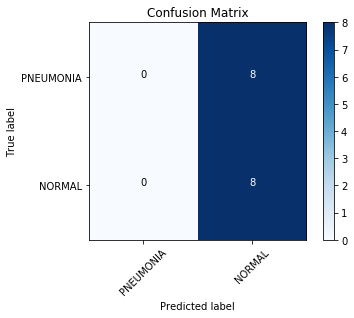

In [209]:
plot_confusion_matrix(val_labels_final, preds3)

# Model 4: L1 & L2 Regularizers on Best Model. Add Greyscale to Data Generator

In [22]:
train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir,
                                                          target_size = (64, 64), batch_size= 7685, color_mode='grayscale')                                                          

Found 7685 images belonging to 2 classes.


In [23]:
val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir,
                                                target_size = (64, 64), batch_size= 16, color_mode='grayscale')                                      



Found 16 images belonging to 2 classes.


In [24]:
test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                target_size = (64, 64), batch_size= 624, color_mode='grayscale')                                      




Found 624 images belonging to 2 classes.


In [25]:
train_imgs, train_lbls = next(train_gen)

In [26]:
val_imgs, val_lbls = next(val_gen)

In [27]:
test_imgs, test_lbls = next(test_gen)

In [142]:
print('Shape of Train Images: ', np.shape(train_imgs))
print('Shape of Train Labels: ', np.shape(train_lbls))
print('Shape of Validation Images: ', np.shape(val_imgs))
print('Shape of Validation Labels: ', np.shape(val_lbls))
print('Shape of Test Images: ', np.shape(test_imgs))
print('Shape of Test Labels: ', np.shape(test_lbls))

Shape of Train Images:  (7685, 64, 64, 1)
Shape of Train Labels:  (7685, 2)
Shape of Validation Images:  (16, 64, 64, 1)
Shape of Validation Labels:  (16, 2)
Shape of Test Images:  (624, 64, 64, 1)
Shape of Test Labels:  (624, 2)


In [28]:
train_lbls_final = np.reshape(train_lbls[:,0], (7685,1))
np.shape(train_lbls_final)

(7685, 1)

In [145]:
val_lbls_final = np.reshape(val_lbls[:,0], (16,1))
np.shape(val_lbls_final)

(16, 1)

In [146]:
test_lbls_final = np.reshape(test_lbls[:,0], (624,1))
np.shape(test_lbls_final)

(624, 1)

In [150]:
for optimizer, d in optimizers.items():
    print(f'Testing {optimizer}')

    # Build the CNN

    # Convolution & Pooling
    model4 = Sequential()
     # Test out a tanh activation function
    model4.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(64, 64, 3)))
    model4.add(layers.MaxPooling2D((2, 2)))
    
    # Add an L2 Regularization to these layers
    model4.add(layers.Conv2D(32, (4, 4), activation='tanh', kernel_regularizer=regularizers.l2(l=0.01)))
    model4.add(layers.MaxPooling2D((2, 2)))

    model4.add(layers.Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=regularizers.l2(l=0.01)))
    model4.add(layers.MaxPooling2D((2,2)))

    # Flattening
    model4.add(layers.Flatten())
    model4.add(layers.Dense(64, activation = 'tanh', kernel_regularizer=regularizers.l2(l=0.01)))
    model4.add(layers.Dense(1, activation='softmax'))

    
    model4.compile(optimizer=d['optimizer'],loss='binary_crossentropy', metrics=['accuracy'])

    
    results4 = model4.fit(train_images, train_labels_final, epochs=11, batch_size=500, validation_data=(val_images, val_labels_final))
# Add a partition to separate the results
    print('='*125)

Testing RMSprop
Train on 7685 samples, validate on 16 samples
Epoch 1/11
7685/7685 [==============================] - 52s 7ms/step - loss: 9.1032 - acc: 0.4958 - val_loss: 8.4972 - val_acc: 0.5000
Epoch 2/11
7685/7685 [==============================] - 48s 6ms/step - loss: 8.3767 - acc: 0.4958 - val_loss: 8.1451 - val_acc: 0.5000
Epoch 3/11
7685/7685 [==============================] - 54s 7ms/step - loss: 8.1451 - acc: 0.4958 - val_loss: 8.0209 - val_acc: 0.5000
Epoch 4/11
7685/7685 [==============================] - 52s 7ms/step - loss: 8.0673 - acc: 0.4958 - val_loss: 7.9828 - val_acc: 0.5000
Epoch 5/11
7685/7685 [==============================] - 50s 7ms/step - loss: 8.0444 - acc: 0.4958 - val_loss: 7.9728 - val_acc: 0.5000
Epoch 6/11
7685/7685 [==============================] - 48s 6ms/step - loss: 8.0393 - acc: 0.4958 - val_loss: 7.9714 - val_acc: 0.5000
Epoch 7/11
7685/7685 [==============================] - 48s 6ms/step - loss: 8.0388 - acc: 0.4958 - val_loss: 7.9715 - val_acc: 

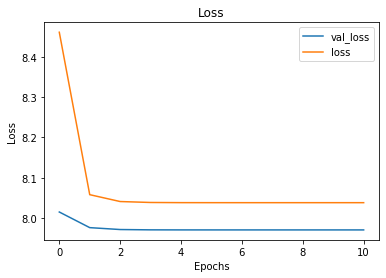

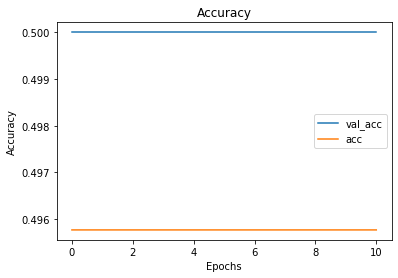

In [204]:
visualize_training_results(results4)

Here the loss converges which is what we want, however the training and validation accuracy does not converge. The model has a high bias and low variance.

In [205]:
model4.evaluate(train_images, train_labels_final)

7685/7685 [==============================] - 27s 4ms/step


[8.03861348518863, 0.4957709824488236]

In [206]:
model4.evaluate(val_images, val_labels_final)

16/16 [==============================] - 0s 9ms/step


[7.971192359924316, 0.5]

In [207]:
preds4 = model4.predict(val_images)

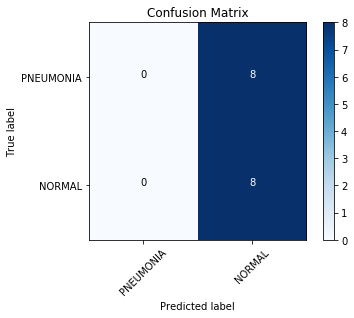

In [210]:
plot_confusion_matrix(val_labels_final, preds4)

# Model 5: Try Increasing Batch Size and Decreasing Learning Rate early stopping

In [158]:
# Build the CNN

# Convolution & Pooling
model5 = Sequential()

model5.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(64, 64, 3)))
model5.add(layers.MaxPooling2D((2, 2)))

model5.add(layers.Conv2D(32, (4, 4), activation='tanh', kernel_regularizer=regularizers.l2(l=0.01)))
model5.add(layers.MaxPooling2D((2, 2)))

model5.add(layers.Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=regularizers.l2(l=0.01)))
model5.add(layers.MaxPooling2D((2,2)))

# Flattening
model5.add(layers.Flatten())
model5.add(layers.Dense(64, activation = 'tanh', kernel_regularizer=regularizers.l2(l=0.01)))
model5.add(layers.Dense(1, activation='softmax'))

# Decrease the learning rate to 0.005 to take smaller "steps"    
model5.compile(optimizer=Adam(lr=0.005),loss='binary_crossentropy', metrics=['accuracy'])

# Increase the batch size, from 500 to 750, to attempt to correct the bias
# Manually stop after if/when the loss and accuracy stops improving after updating the activation functions and batch size
results5 = model5.fit(train_images, train_labels_final, epochs=15, batch_size=750, validation_data=(val_images, val_labels_final))

print('='*120)

Train on 7685 samples, validate on 16 samples
Epoch 1/15
7685/7685 [==============================] - 75s 10ms/step - loss: 8.7736 - acc: 0.4958 - val_loss: 8.0791 - val_acc: 0.5000
Epoch 2/15
7685/7685 [==============================] - 58s 8ms/step - loss: 8.1469 - acc: 0.4958 - val_loss: 8.0424 - val_acc: 0.5000
Epoch 3/15
7685/7685 [==============================] - 57s 7ms/step - loss: 8.0808 - acc: 0.4958 - val_loss: 7.9937 - val_acc: 0.5000
Epoch 4/15
7685/7685 [==============================] - 60s 8ms/step - loss: 8.0532 - acc: 0.4958 - val_loss: 7.9768 - val_acc: 0.5000
Epoch 5/15
7685/7685 [==============================] - 79s 10ms/step - loss: 8.0428 - acc: 0.4958 - val_loss: 7.9740 - val_acc: 0.5000
Epoch 6/15
7685/7685 [==============================] - 56s 7ms/step - loss: 8.0402 - acc: 0.4958 - val_loss: 7.9718 - val_acc: 0.5000
Epoch 7/15
7685/7685 [==============================] - 59s 8ms/step - loss: 8.0391 - acc: 0.4958 - val_loss: 7.9714 - val_acc: 0.5000
Epoch 8

KeyboardInterrupt: 

## Model 6: Reduce the amount of Layers, Increase Batch Size

In [160]:
model6 = Sequential()

model6.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(64, 64, 3)))
model6.add(layers.MaxPooling2D((2, 2)))

model6.add(layers.Flatten())
model6.add(layers.Dense(64, activation = 'tanh', kernel_regularizer=regularizers.l2(l=0.005)))
model6.add(layers.Dense(1, activation='softmax'))

# Decrease learning rate for the Adam optimizer
model6.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy', metrics=['accuracy'])
# Increase batch size from 750 to 1000
results6 = model6.fit(train_images, train_labels_final, epochs=15, batch_size=1000, validation_data=(val_images, val_labels_final))

Train on 7685 samples, validate on 16 samples
Epoch 1/15
7685/7685 [==============================] - 31s 4ms/step - loss: 8.3651 - acc: 0.4958 - val_loss: 8.0388 - val_acc: 0.5000
Epoch 2/15
7685/7685 [==============================] - 27s 3ms/step - loss: 8.0705 - acc: 0.4958 - val_loss: 7.9943 - val_acc: 0.5000
Epoch 3/15
7685/7685 [==============================] - 33s 4ms/step - loss: 8.0659 - acc: 0.4958 - val_loss: 7.9961 - val_acc: 0.5000
Epoch 4/15
7685/7685 [==============================] - 30s 4ms/step - loss: 8.0553 - acc: 0.4958 - val_loss: 7.9780 - val_acc: 0.5000
Epoch 5/15
7685/7685 [==============================] - 42s 6ms/step - loss: 8.0427 - acc: 0.4958 - val_loss: 7.9738 - val_acc: 0.5000
Epoch 6/15
7685/7685 [==============================] - 31s 4ms/step - loss: 8.0411 - acc: 0.4958 - val_loss: 7.9732 - val_acc: 0.5000
Epoch 7/15
7685/7685 [==============================] - 27s 3ms/step - loss: 8.0399 - acc: 0.4958 - val_loss: 7.9718 - val_acc: 0.5000
Epoch 8/1

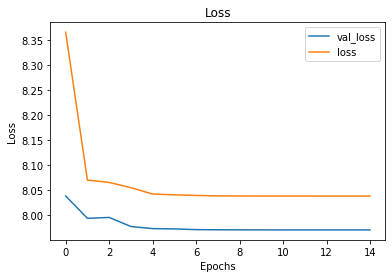

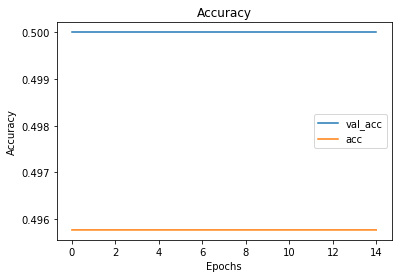

In [212]:
visualize_training_results(results6)

The loss fluctuates at 2 epochs, then continues to decrease, and remains constant after 4 epochs.

In [213]:
model6.evaluate(train_images, train_labels_final)

7685/7685 [==============================] - 13s 2ms/step


[8.038614438862947, 0.4957709824488236]

In [214]:
model6.evaluate(val_images, val_labels_final)

16/16 [==============================] - 0s 7ms/step


[7.971193313598633, 0.5]

In [215]:
preds6 = model6.predict(val_images)

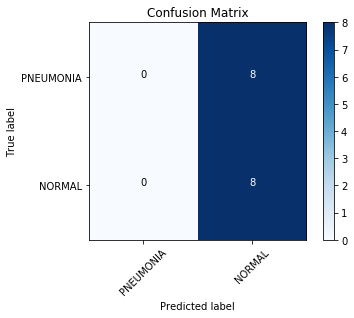

In [217]:
plot_confusion_matrix(val_labels_final, preds6)

# Model 7: Validate Model with Test Set

In [13]:
# Build the CNN

# Convolution & Pooling
model7 = Sequential()

# Return to original layer count
model7.add(layers.Conv2D(32, (3, 3), activation='tanh', input_shape=(64, 64, 3)))
model7.add(layers.MaxPooling2D((2, 2)))

model7.add(layers.Conv2D(32, (4, 4), activation='tanh', kernel_regularizer=regularizers.l2(l=0.01)))
model7.add(layers.MaxPooling2D((2, 2)))

model7.add(layers.Conv2D(64, (3, 3), activation='tanh', kernel_regularizer=regularizers.l2(l=0.01)))
model7.add(layers.MaxPooling2D((2,2)))

# Flattening
model7.add(layers.Flatten())
model7.add(layers.Dense(64, activation = 'tanh', kernel_regularizer=regularizers.l2(l=0.01)))
model7.add(layers.Dense(1, activation='softmax'))

    
model7.compile(optimizer=Adam(lr=0.01),loss='binary_crossentropy', metrics=['accuracy'])

    
results7 = model7.fit(train_images, train_labels_final, epochs=11, batch_size=750, validation_data=(test_images, test_labels_final))



Train on 7685 samples, validate on 624 samples
Epoch 1/11
7685/7685 [==============================] - 69s 9ms/step - loss: 8.5613 - acc: 0.4958 - val_loss: 10.1806 - val_acc: 0.3750
Epoch 2/11
7685/7685 [==============================] - 84s 11ms/step - loss: 8.1558 - acc: 0.4958 - val_loss: 10.0222 - val_acc: 0.3750
Epoch 3/11
7685/7685 [==============================] - 67s 9ms/step - loss: 8.0733 - acc: 0.4958 - val_loss: 9.9854 - val_acc: 0.3750
Epoch 4/11
7685/7685 [==============================] - 67s 9ms/step - loss: 8.0508 - acc: 0.4958 - val_loss: 9.9702 - val_acc: 0.3750
Epoch 5/11
7685/7685 [==============================] - 72s 9ms/step - loss: 8.0428 - acc: 0.4958 - val_loss: 9.9658 - val_acc: 0.3750
Epoch 6/11
7685/7685 [==============================] - 63s 8ms/step - loss: 8.0399 - acc: 0.4958 - val_loss: 9.9646 - val_acc: 0.3750
Epoch 7/11
7685/7685 [==============================] - 69s 9ms/step - loss: 8.0390 - acc: 0.4958 - val_loss: 9.9642 - val_acc: 0.3750
Epoch

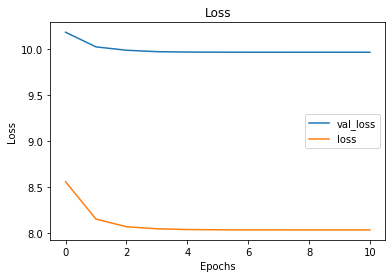

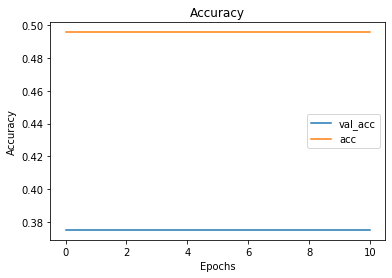

In [16]:
visualize_training_results(results7)

The loss has increased between the traing and test set. The bias and variance in the model has increased, with the training accuracy being 0.50, and the testing accuracy is 0.375. In upcoming projects, given the proper tech tools, I want to double the amount of images, increase the amount of hidden layers to reveal more features, and increase the size of the images to 150 x 150 so that the model is able to capture more features, and experiment with the neuron count.

In [17]:
model7.evaluate(train_images, train_labels_final)

7685/7685 [==============================] - 16s 2ms/step


[8.038615184056736, 0.49577098243718964]

In [18]:
model7.evaluate(test_images, test_labels_final)

624/624 [==============================] - 1s 2ms/step


[9.963992253327982, 0.375]

In [19]:
test_preds = model7.predict(test_images)

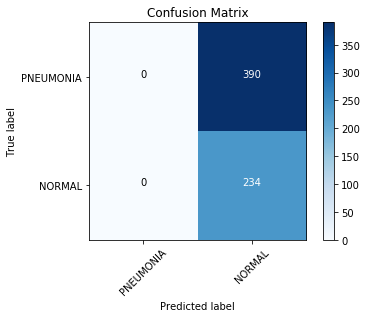

In [20]:
plot_confusion_matrix(test_labels_final, test_preds)

In [47]:
# Save the model
# print('saving model to disk \n')
# mod = './/Models/final_scratchmod'
# model7.save(mod)

# Model 9: Transfer Learning

In [15]:
# Update the input shape from the default settings of the VGG16
# model to (64, 64, 3) the input shape of the training images
pretrain_mod1 = VGG16(include_top= False, input_shape=(64,64,3))

In [12]:
# Review the summary of the model
pretrain_mod1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
__________

In [16]:
model9 = Sequential()

# Import the pretrained model (layers)
model9.add(pretrain_mod1)

# Add the 1D Layer
model9.add(layers.Flatten())
model9.add(layers.Dense(132, activation='tanh'))
model9.add(layers.Dense(1, activation='softmax'))



In [17]:
# Check whether the layer is trainable (or alter its setting)
for layer in model9.layers:
    print(layer.name, layer.trainable)
    
# Check how many trainable weights are in the model
print(len(model9.trainable_weights))

vgg16 True
flatten_1 True
dense_1 True
dense_2 True
30


In [18]:
# Freeze the convolutional base all of the weights associated 
# with that layer(s) will remain unchanged through the optimization process)
pretrain_mod1.trainable = False

In [19]:
# Do a sanity check to make sure the 
# layers were actually frozen
for layer in model9.layers:
    print(layer.name, layer.trainable)

print(len(model9.trainable_weights))

vgg16 False
flatten_1 True
dense_1 True
dense_2 True
4


In [20]:
model9.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

In [21]:
results9 = model9.fit(train_images, train_labels_final, epochs=11, batch_size=750, validation_data=(test_images, test_labels_final))

Train on 7685 samples, validate on 624 samples
Epoch 1/11
7685/7685 [==============================] - 833s 108ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 9.9640 - val_acc: 0.3750
Epoch 2/11
7685/7685 [==============================] - 883s 115ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 9.9640 - val_acc: 0.3750
Epoch 3/11
7685/7685 [==============================] - 807s 105ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 9.9640 - val_acc: 0.3750
Epoch 4/11
7685/7685 [==============================] - 738s 96ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 9.9640 - val_acc: 0.3750
Epoch 5/11
7685/7685 [==============================] - 679s 88ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 9.9640 - val_acc: 0.3750
Epoch 6/11
7685/7685 [==============================] - 737s 96ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 9.9640 - val_acc: 0.3750
Epoch 7/11
7685/7685 [==============================] - 632s 82ms/step - loss: 8.0386 - acc: 0.4958 - val_loss: 9.9640 - val_acc

In [24]:
vgg_preds = model9.predict(test_images)


In [26]:
model9.evaluate(train_images, train_labels_final)

7685/7685 [==============================] - 341s 44ms/step


[8.038613455405697, 0.4957709824488236]

In [27]:
model9.evaluate(test_images, test_labels_final)

624/624 [==============================] - 22s 36ms/step


[9.96399109180157, 0.375]

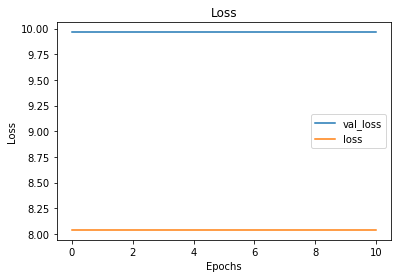

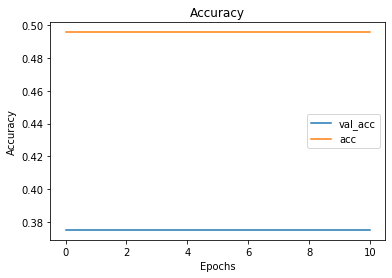

In [28]:
visualize_training_results(results9)

The results of the pretrained model, faired the same as the results from my final model. In addition to the improvements above, to improve upon this model, I will alter the neurons in the desne layers, and use feature extraction as a means of fine tuning. 

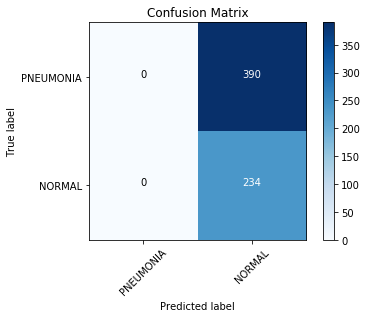

In [29]:
plot_confusion_matrix(test_labels_final, vgg_preds)

In [30]:
# Save the pretrained model with the file name "pretrained_mod9"
print('saving model to disk \n')
mod = './/Models/pretrained_mod9'
model9.save(mod)

saving model to disk 

